# Data preparation

## Set up

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score

## Load data

In [2]:
with open("MLA_100k.jsonlines", 'r') as file:
    data = [json.loads(line) for line in file]
df = pd.json_normalize(data)

# Goal: Extract main dictionaries from jsonlines
columns_to_keep_nested = ['seller_address', 'location', 'seller_contact', 'geolocation']
processed_data = []

for record in data:
    processed_record = {}
    for key, value in record.items():

        if key in columns_to_keep_nested:
            processed_record[key] = value 
        else:
            processed_record[key] = value
    processed_data.append(processed_record)

df = pd.DataFrame(processed_data)


## Data transformation

### Functions

In [3]:
def process_columns_with_empty_lists(dtf, columns):
    """
    Processes the specified columns in the DataFrame by converting them to strings, 
    replacing empty lists ('[]') with NaN, and creating a new boolean column indicating 
    whether the original column contains data or is missing.

    Parameters:
    dtf (pd.DataFrame): The DataFrame to be processed.
    columns (list): List of column names to be processed.

    Returns:
    pd.DataFrame: The modified DataFrame with additional boolean columns 
                  in the format 'have_{column_name}' for each processed column.

    Behavior:
    - Converts each specified column to string format.
    - Replaces any occurrence of '[]' (empty list representation) with NaN.
    - Creates a new column 'have_{column_name}' with a boolean indicator: 
      1 if the original column has data, 0 otherwise.
    - If a column is not found in the DataFrame, it prints a warning.
    
    """
    for col in columns:
        if col in dtf.columns:
            # Convert the column to string and replace empty lists with NaN
            dtf[col] = dtf[col].astype(str)
            dtf[col] = dtf[col].replace('[]', np.nan)
            # Create a boolean column indicating if there is data
            dtf[f'have_{col}'] = dtf[col].notnull().astype(int)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    
    return dtf

In [4]:
def create_boolean_columns(dtf, columns):
    """
    Automates the creation of boolean columns indicating whether the specified columns
    contain data (not null). For each column, a new boolean column named 'have_{column_name}'
    is created, where 1 indicates the presence of data and 0 indicates missing data.

    Parameters:
    dtf (pd.DataFrame): The DataFrame to be processed.
    columns (list): List of column names to process.

    Returns:
    pd.DataFrame: The modified DataFrame with the new boolean columns.

    Example:
    columns_to_process = ['official_store_id', 'parent_item_id', 'video_id', 'original_price', 'seller_contact']
    dtf = create_boolean_columns(dtf, columns_to_process)
    """
    for col in columns:
        if col in dtf.columns:
            # Create a boolean column indicating if the original column has data
            dtf[f'have_{col}'] = dtf[col].notnull().astype(int)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    
    return dtf

### Process

In [5]:
dtf = df.copy()

In [6]:
columns_with_empty_list = ['deal_ids', 'variations', 'attributes', 'descriptions', 'pictures']
dtf = process_columns_with_empty_lists(dtf, columns_with_empty_list)

columns_to_boolean = ['official_store_id', 'parent_item_id', 'video_id', 'original_price', 'seller_contact']
dtf = create_boolean_columns(dtf, columns_to_boolean)

## One to one set up specific columns 
# accepts_mercadopago
dtf['accepts_mercadopago'] = dtf['accepts_mercadopago'].astype(int)

# automatic_relist
dtf['have_automatic_relist'] = dtf['automatic_relist'].astype(int)

# category_id 
dtf['category_id'] = dtf['category_id'].str.strip()

# shipping
dtf['local_pick_up'] = dtf['shipping'].apply(lambda x: x.get('local_pick_up'))
dtf['local_pick_up'] = dtf['local_pick_up'].astype(int)
dtf['free_shipping'] = dtf['shipping'].apply(lambda x: x.get('free_shipping'))
dtf['free_shipping'] = dtf['free_shipping'].astype(int)

# location
dtf['location'] = dtf['location'].astype(str)
dtf['location'] = dtf['location'].replace('{}', np.nan)
dtf['have_location'] = dtf['location'].notnull().astype(int)

# sub_status
dtf['sub_status'] = dtf['sub_status'].astype(str)
dtf['sub_status'] = dtf['sub_status'].str.strip()
dtf['sub_status'] = dtf['sub_status'].replace('[]', 'no_status')
dtf['sub_status'] = dtf['sub_status'].str.replace(r"[\[\]']", '', regex=True)

# tags
dtf['tags'] = dtf['tags'].apply(lambda x: x if isinstance(x, list) else [])
tags_dummies = dtf['tags'].apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int)
dtf = pd.concat([dtf, tags_dummies], axis=1)


In [7]:
dtf.buying_mode.value_counts()

buy_it_now    97001
classified     2219
auction         780
Name: buying_mode, dtype: int64

## Data to model

In [8]:
columns_to_model = ['id', 'condition','category_id','sub_status', 'have_seller_contact', 'have_deal_ids' ,'free_shipping', 'local_pick_up', 
                    'have_variations', 'have_location', 'listing_type_id', 'have_attributes', 'buying_mode', 'dragged_bids_and_visits', 
                    'good_quality_thumbnail', 'dragged_visits', 'free_relist', 'poor_quality_thumbnail', 'have_parent_item_id', 'have_descriptions', 
                    'have_pictures', 'have_official_store_id', 'accepts_mercadopago', 'have_original_price', 'have_automatic_relist', 'have_video_id',
                    'initial_quantity', 'sold_quantity', 'available_quantity', 'base_price']

df_to_model = dtf[columns_to_model]

categorical_columns = ['sub_status', 'listing_type_id', 'buying_mode', 'category_id']
df_onehot = pd.get_dummies(df_to_model[categorical_columns])

df_to_model_encoded = pd.concat([df_to_model, df_onehot], axis=1)
df_to_model_encoded.drop(categorical_columns, axis=1, inplace=True)

df_to_model_encoded['target_condition'] = df_to_model_encoded['condition'].apply(lambda x: 1 if x == 'new' else 0)
df_to_model_encoded 

,id,condition,have_seller_contact,have_deal_ids,free_shipping,local_pick_up,have_variations,have_location,have_attributes,dragged_bids_and_visits,...,category_id_MLA9984,category_id_MLA9988,category_id_MLA9990,category_id_MLA9991,category_id_MLA9992,category_id_MLA9996,category_id_MLA9999,category_id_MLA99991,category_id_MLA99994,target_condition
0,MLA578052519,new,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,MLA581565358,used,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MLA578780872,used,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,MLA581877385,new,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,MLA576112692,used,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,MLA581735252,used,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,MLA579045843,new,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99997,MLA578170688,used,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99998,MLA575062152,used,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#, 'category_id'

df_to_model_encoded.columns

Index(['id', 'condition', 'have_seller_contact', 'have_deal_ids',
       'free_shipping', 'local_pick_up', 'have_variations', 'have_location',
       'have_attributes', 'dragged_bids_and_visits',
       ...
       'category_id_MLA9984', 'category_id_MLA9988', 'category_id_MLA9990',
       'category_id_MLA9991', 'category_id_MLA9992', 'category_id_MLA9996',
       'category_id_MLA9999', 'category_id_MLA99991', 'category_id_MLA99994',
       'target_condition'],
      dtype='object', length=10948)

## Best model: CatBoost 

Include category_id

In [10]:
dfm = df_to_model_encoded.copy()
dfm = dfm.drop('condition', axis=1)
dfm

,id,have_seller_contact,have_deal_ids,free_shipping,local_pick_up,have_variations,have_location,have_attributes,dragged_bids_and_visits,good_quality_thumbnail,...,category_id_MLA9984,category_id_MLA9988,category_id_MLA9990,category_id_MLA9991,category_id_MLA9992,category_id_MLA9996,category_id_MLA9999,category_id_MLA99991,category_id_MLA99994,target_condition
0,MLA578052519,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,MLA581565358,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MLA578780872,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,MLA581877385,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,MLA576112692,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,MLA581735252,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99996,MLA579045843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99997,MLA578170688,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,MLA575062152,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [12]:
X = dfm.drop(columns=['id', 'target_condition'])  
y = dfm['target_condition']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=10000, random_state=42)

model_catboost = CatBoostClassifier(random_state=42, silent=True)  
model_catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, plot=True)

# Predictions
y_pred_catboost = model_catboost.predict(X_val)

# Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_catboost))
print("Classification Report:\n", classification_report(y_val, y_pred_catboost))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.096296
0:	learn: 0.6134719	test: 0.6136849	best: 0.6136849 (0)	total: 229ms	remaining: 3m 48s
100:	learn: 0.3408156	test: 0.3451438	best: 0.3451438 (100)	total: 5.17s	remaining: 46s
200:	learn: 0.3259969	test: 0.3325173	best: 0.3325173 (200)	total: 10s	remaining: 39.9s
300:	learn: 0.3165001	test: 0.3253042	best: 0.3253042 (300)	total: 14.8s	remaining: 34.4s
400:	learn: 0.3085969	test: 0.3197070	best: 0.3197070 (400)	total: 19.6s	remaining: 29.2s
500:	learn: 0.3020333	test: 0.3149490	best: 0.3149490 (500)	total: 24.3s	remaining: 24.2s
600:	learn: 0.2973670	test: 0.3121606	best: 0.3121606 (600)	total: 29.5s	remaining: 19.6s
700:	learn: 0.2933760	test: 0.3098286	best: 0.3098286 (700)	total: 34.5s	remaining: 14.7s
800:	learn: 0.2899400	test: 0.3080841	best: 0.3080841 (800)	total: 39.5s	remaining: 9.8s
900:	learn: 0.2867173	test: 0.3063647	best: 0.3063638 (899)	total: 44.2s	remaining: 4.86s
999:	learn: 0.2835879	test: 0.3048361	best: 0.3048361 (999)	total: 48.9s	remai

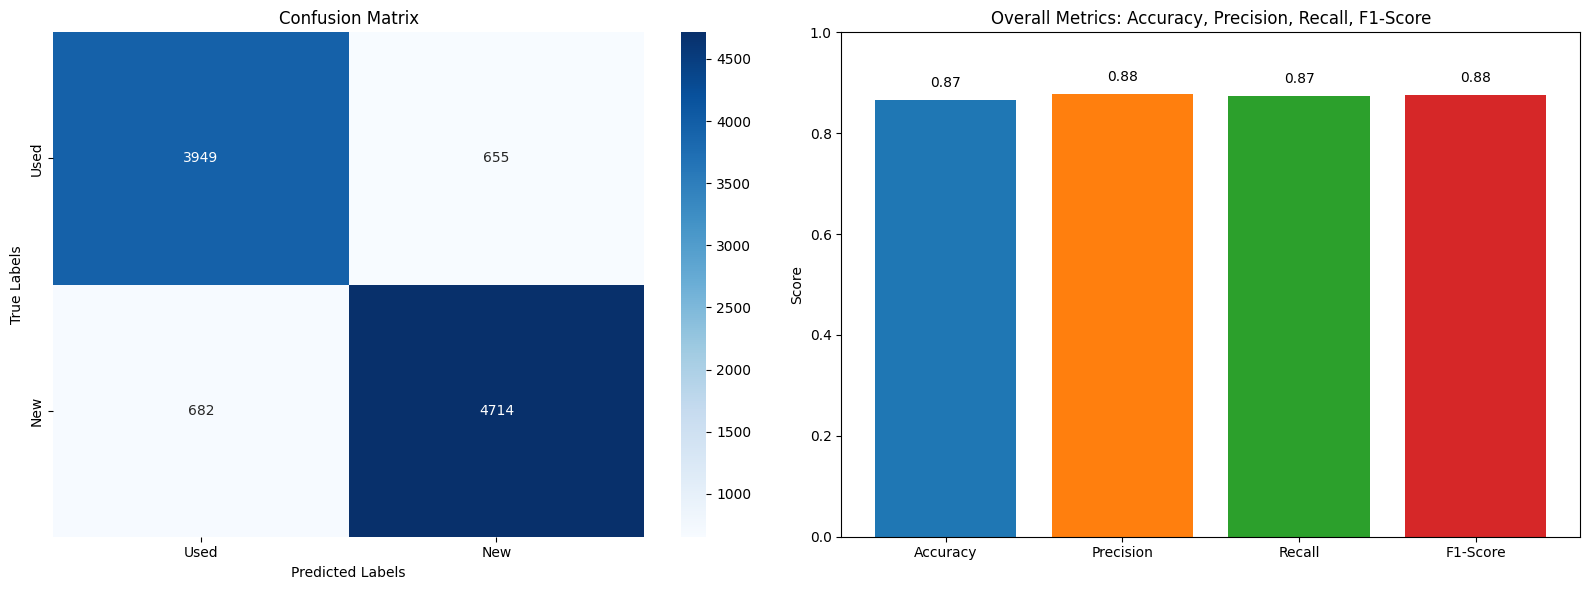

In [55]:
conf_matrix = confusion_matrix(y_val, y_pred_catboost)
accuracy = accuracy_score(y_val, y_pred_catboost)
precision = precision_score(y_val, y_pred_catboost)
recall = recall_score(y_val, y_pred_catboost)
f1 = f1_score(y_val, y_pred_catboost)

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 1
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Used', 'New'], yticklabels=['Used', 'New'], ax=axs[0])
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

# 2.
bars = axs[1].bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

axs[1].set_title('Overall Metrics: Accuracy, Precision, Recall, F1-Score')
axs[1].set_ylabel('Score')
axs[1].set_ylim(0, 1)  

plt.tight_layout()
plt.show()

In [71]:
# Métricas en el conjunto de entrenamiento
y_train_pred = model_catboost.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Métricas en el conjunto de validación
y_val_pred = model_catboost.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"F1-Score en entrenamiento: {train_f1:.4f}")

print(f"Accuracy en validación: {val_accuracy:.4f}")
print(f"F1-Score en validación: {val_f1:.4f}")

Accuracy en entrenamiento: 0.8762
F1-Score en entrenamiento: 0.8844
Accuracy en validación: 0.8663
F1-Score en validación: 0.8758


In [66]:
feature_importances = model_catboost.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.1]
important_features.head()

,Feature,Importance
29,listing_type_id_free,24.759541
20,initial_quantity,20.178701
22,available_quantity,10.494479
23,base_price,9.828041
21,sold_quantity,4.576711


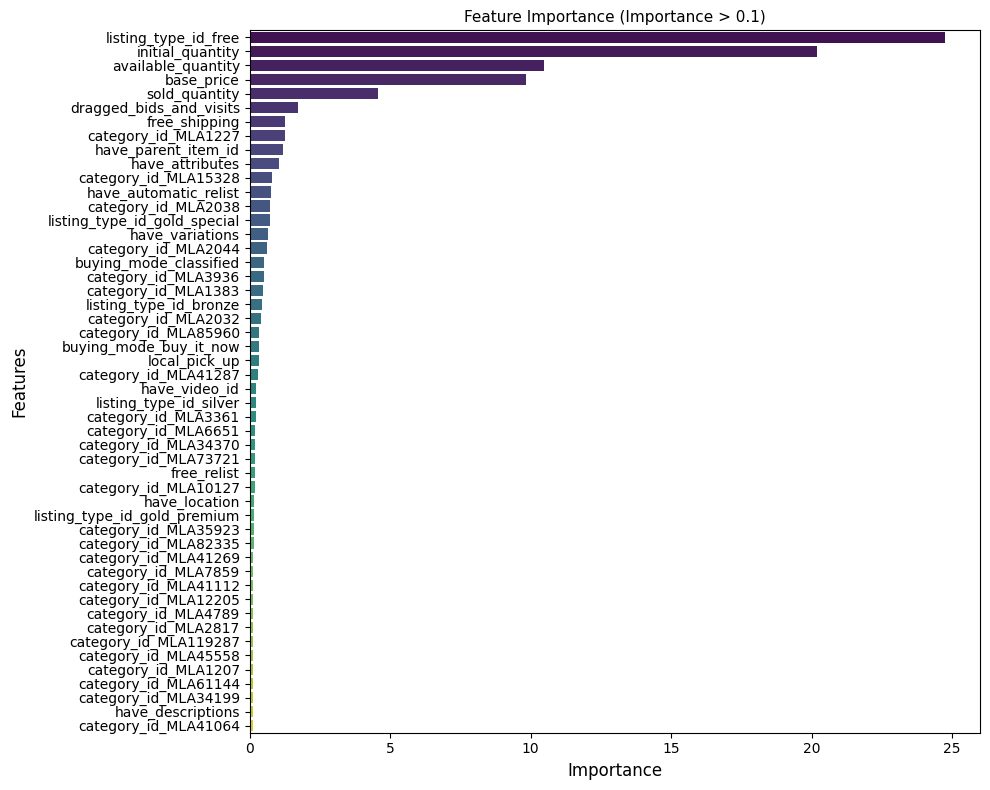

In [70]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=important_features, palette='viridis')
plt.title('Feature Importance (Importance > 0.1)', fontsize=11)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Dividir el dataframe en características (X) y objetivo (y)
X = df.drop(columns=['id', 'target_condition'])  # Eliminar columnas no usadas para el modelo
y = df['target_condition']

# Dividir datos en entrenamiento y validación (10000 para validación)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=10000, random_state=42)

# Crear el modelo de Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42, n_estimators=150, learning_rate=0.1, max_depth=7, min_samples_split=10, subsample=0.9)

# Entrenar el modelo
model_gb.fit(X_train, y_train)

# Hacer predicciones en los datos de validación
y_pred_gb = model_gb.predict(X_val)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_val, y_pred_gb))
print("Classification Report:\n", classification_report(y_val, y_pred_gb))

Accuracy: 0.855
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      4604
           1       0.87      0.87      0.87      5396

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

